# 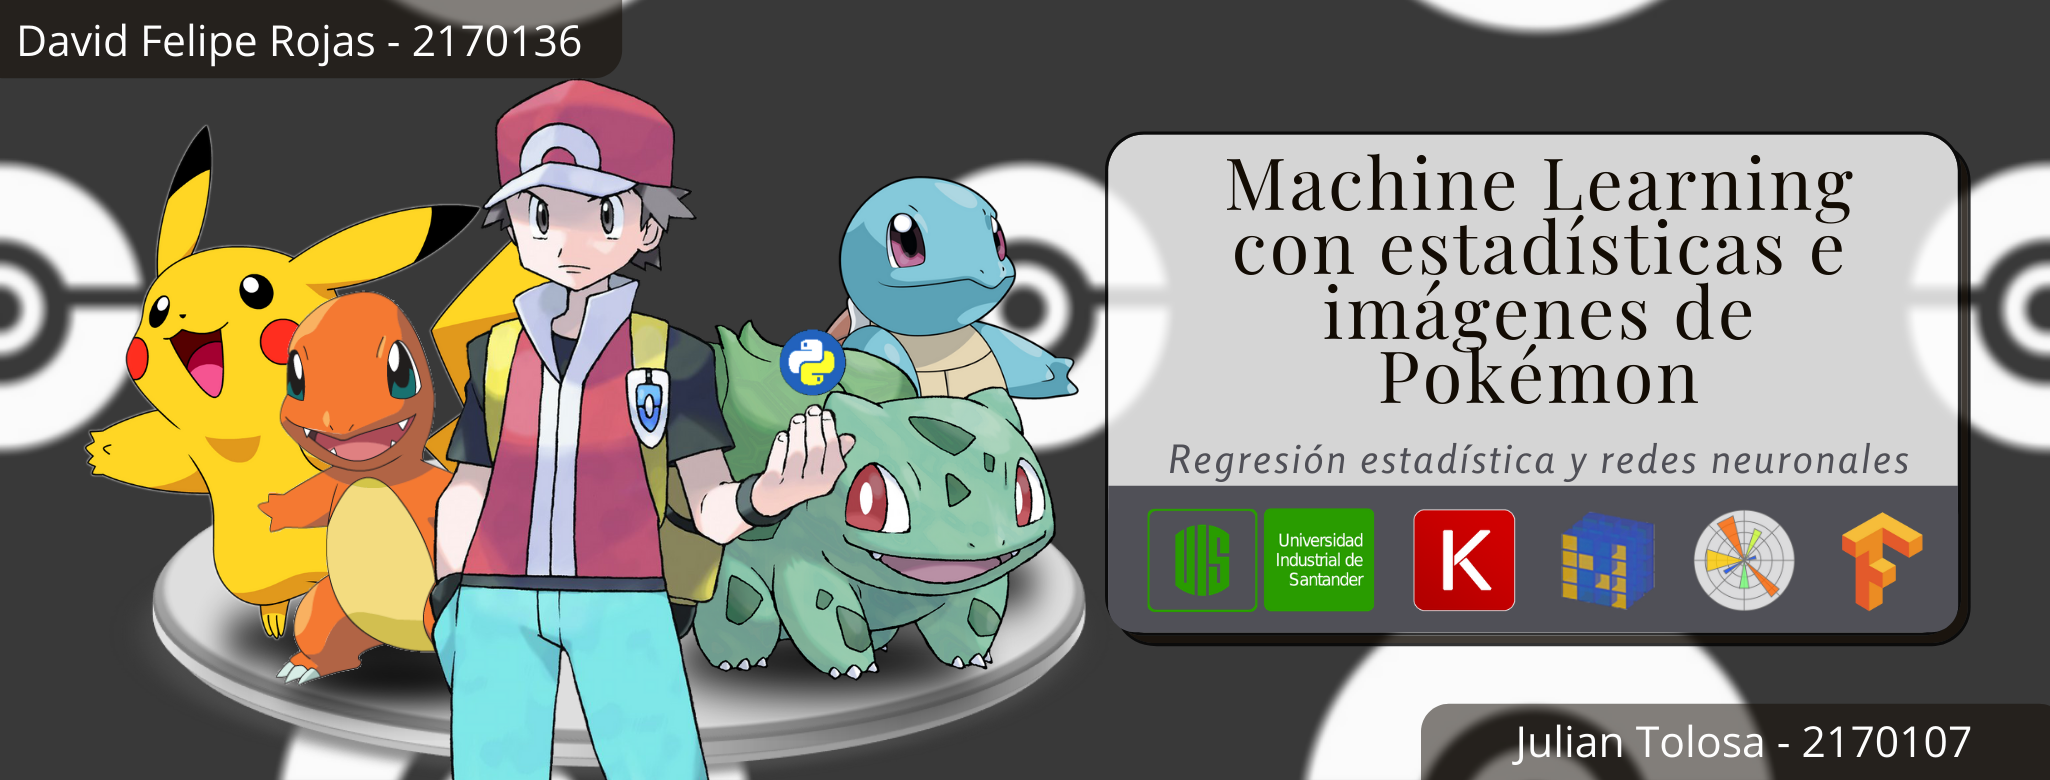

In [ ]:
#@title MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/IA/Proyecto')
print(os.getcwd())

In [ ]:
#@title Importar librerías { display-mode: "form" }

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

### Definimos los datasets pokemon y combate

In [ ]:
pokemon = pd.read_csv("pokemon.csv")
#renombramos la columna "#" por "Number" ya que la necesitaremos luego
pokemon = pokemon.rename(index=str, columns={"#": "Number"})
combate = pd.read_csv("combats.csv")
pokemon.head()

,Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [ ]:
combate.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [ ]:
print("Dimensiones del dataset Pokemon: " + str(pokemon.shape))
print("Dimenstions del dataset Combate: " + str(combate.shape))

Dimensiones del dataset Pokemon: (800, 12)
Dimenstions del dataset Combate: (50000, 3)


Miremos cuáles son los tipos de Pokémon más frecuentes a continuación.

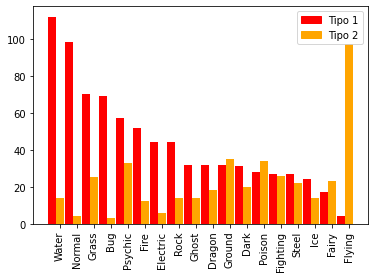

In [ ]:
valores1 = [pokemon['Type 1'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
valores2 = [pokemon['Type 2'].value_counts()[key] for key in pokemon['Type 1'].value_counts().index]
inds = np.arange(len(pokemon['Type 1'].value_counts().index))
width = .45
handles = [patches.Patch(color='red', label='Tipo 1'), patches.Patch(color='orange', label='Tipo 2')]
plt.bar(inds, valores1, width, color='red')
plt.bar(inds+width, valores2, width, color='orange')
plt.gca().set_xticklabels(pokemon['Type 1'].value_counts().index)
plt.gca().set_xticks(inds+width)
plt.xticks(rotation=90)
plt.legend(handles=handles)

El agua es el tipo más común en el ataque primario, mientras que el volador es el tipo más común en el ataque secundario.

### Pokémon por generación

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64


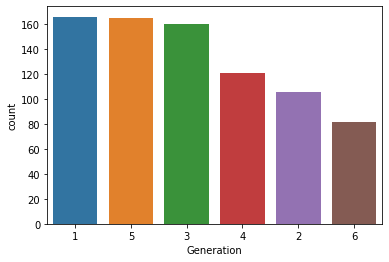

In [ ]:
print(pokemon['Generation'].value_counts())

sns.countplot(x='Generation', data=pokemon, order=pokemon['Generation'].value_counts().index)
plt.show()

Miremos si cada vez los pokémon tienen mejores estadísticas entre cada generación:

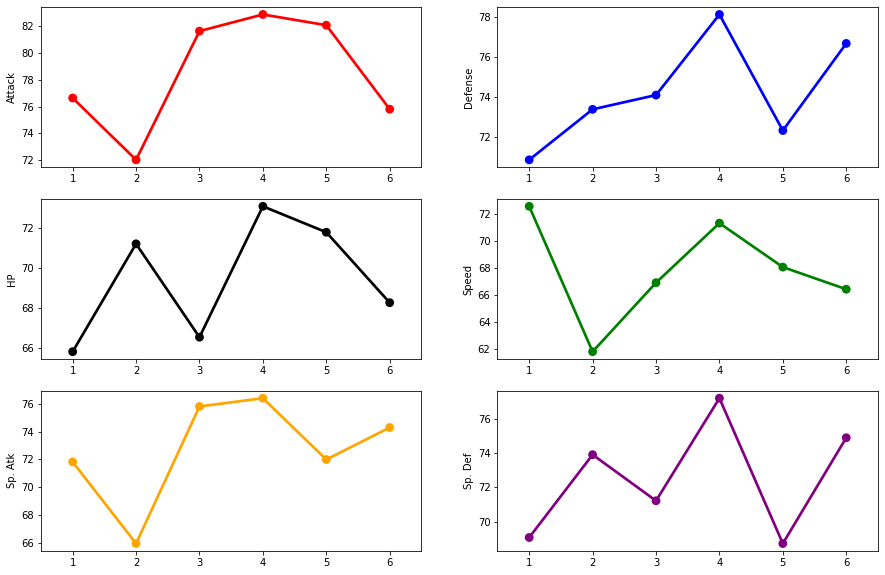

In [ ]:
group_df = pokemon.drop(['Number', 'Legendary'], axis=1)
pokemon_groups = group_df.groupby('Generation')
pokemon_groups_mean = pokemon_groups.mean()
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Attack'], color='red', ax=axes[0][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Defense'], color='blue', ax=axes[0][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['HP'], color='black', ax=axes[1][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Speed'], color='green', ax=axes[1][1])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Atk'], color='orange', ax=axes[2][0])
sns.pointplot(x=pokemon_groups_mean.index.values, y=pokemon_groups_mean['Sp. Def'], color='purple', ax=axes[2][1])

plt.show()

### Datos que faltan en el dataset  

In [ ]:
pokemon.isnull().sum()

Number          0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [ ]:
combate.isnull().sum()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

Como podemos observar, hay 386 Pokémon que no tienen asignado un valor en la columna "Type 2". Esto es debido a que algunos pokémon no tienen un tipo secundario.
También hay un Pokémon el cual sale sin nombre en el dataset y procederemos a ver cuál es.

In [ ]:
print(pokemon[pokemon['Name'].isnull()])

    Number Name    Type 1 Type 2  ...  Sp. Def  Speed  Generation  Legendary
62      63  NaN  Fighting    NaN  ...       70     95           1      False

[1 rows x 12 columns]


Asumiendo que el dataset siga el mismo enumerado de la Pokedex tradicional, podemos saber cuál pokémon es el que falta con número 63. En este caso sería Primeape.

In [ ]:
pokemon['Name'][62] = "Primeape"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### **Porcentaje de victorias para cada Pokémon**

Ahora con el dataset "combate" calcularemos el porcentaje de victorias para cada pokémon.

In [ ]:
# calcular el porcentaje de victorias para cada pokemon
totalvictorias = combate.Winner.value_counts()
# obtener el numero de victorias para cada pokemon
numerovictorias = combate.groupby('Winner').count()

contarprimero = combate.groupby('Second_pokemon').count()
contarsegundo = combate.groupby('First_pokemon').count()
print("Dimensiones de nuestros dataframes:")
print("Contador para primer ganador: " + str(contarprimero.shape))
print("Contador para segundo ganador: " + str(contarsegundo.shape))
print("Total de victorias: " + str(numerovictorias.shape))

Dimensiones de nuestros dataframes:
Contador para primer ganador: (784, 2)
Contador para segundo ganador: (784, 2)
Total de victorias: (783, 2)


Podemos ver que el shape en total de victorias es diferente al de los demás. Esto nos indica que hubo un pokémon el cual no pudo ganar en las batallas. Procederemos entonces a hallar cuál fue.

In [ ]:
buscar_pokemon_perdedor= np.setdiff1d(contarprimero.index.values, numerovictorias.index.values)-1 #offset because the index and number are off by one
pokemon_perdedor = pokemon.iloc[buscar_pokemon_perdedor[0],]
print(pokemon_perdedor)

Number            231
Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
Name: 230, dtype: object


En este caso el pokémon que no pudo ganar ninguna batalla fue Shuckle.

Ahora creamos una nueva columna llamada "Porcentaje de Victorias", combinando los datasets pokemon y combate.

In [ ]:
numerovictorias = numerovictorias.sort_index()
numerovictorias['batallastotales'] = contarprimero.Winner + contarsegundo.Winner
numerovictorias['porcenvictoria']= numerovictorias.First_pokemon/numerovictorias['batallastotales']

# unir los datasets
results2 = pd.merge(pokemon, numerovictorias, right_index = True, left_on='Number')
results3 = pd.merge(pokemon, numerovictorias, left_on='Number', right_index = True, how='left')

# miremos cuales pokemon no han tenido batallas
results3[results3['porcenvictoria'].isnull()]

,Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,batallastotales,porcenvictoria
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,NaN,NaN,NaN,NaN
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,NaN,NaN,NaN,NaN
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,NaN,NaN,NaN,NaN
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,NaN,NaN,NaN,NaN
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,NaN,NaN,NaN,NaN
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,NaN,NaN,NaN,NaN
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,NaN,NaN,NaN,NaN
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,NaN,NaN,NaN,NaN
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,NaN,NaN,NaN,NaN
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False,NaN,NaN,NaN,NaN


Como podemos ver, hay algunos pokémon que no participaron en ninguna batalla.

### Top 10 Pokemon con el peor porcentaje de victorias

In [ ]:
results3[np.isfinite(results3['porcenvictoria'])].sort_values(by = ['porcenvictoria']).head(10)

,Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,batallastotales,porcenvictoria
289,290,Silcoon,Bug,NaN,50,35,55,25,25,15,3,False,3.0,3.0,138.0,0.021739
189,190,Togepi,Fairy,NaN,35,20,65,40,65,20,2,False,3.0,3.0,122.0,0.024590
638,639,Solosis,Psychic,NaN,45,30,40,105,50,20,5,False,4.0,4.0,129.0,0.031008
236,237,Slugma,Fire,NaN,40,40,40,70,40,20,2,False,4.0,4.0,123.0,0.032520
576,577,Munna,Psychic,NaN,76,25,45,67,55,24,5,False,5.0,5.0,128.0,0.039062
188,189,Igglybuff,Normal,Fairy,90,30,15,40,20,15,2,False,5.0,5.0,115.0,0.043478
394,395,Wynaut,Psychic,NaN,95,23,48,23,48,23,3,False,6.0,6.0,130.0,0.046154
209,210,Wooper,Water,Ground,55,45,45,25,25,15,2,False,6.0,6.0,125.0,0.048000
291,292,Cascoon,Bug,NaN,50,35,55,25,25,15,3,False,7.0,7.0,133.0,0.052632
752,753,Spritzee,Fairy,NaN,78,52,60,63,65,23,6,False,8.0,8.0,133.0,0.060150


### Top 10 Pokemon con el mejor porcentaje de victorias

In [ ]:
results3[np.isfinite(results3['porcenvictoria'])].sort_values(by = ['porcenvictoria'], ascending = False ).head(10)

,Number,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,First_pokemon,Second_pokemon,batallastotales,porcenvictoria
154,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False,127.0,127.0,129.0,0.984496
512,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False,116.0,116.0,119.0,0.974790
703,704,Tornadus Therian Forme,Flying,NaN,79,100,80,110,90,121,5,True,121.0,121.0,125.0,0.968000
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False,115.0,115.0,119.0,0.966387
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False,136.0,136.0,141.0,0.964539
476,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False,124.0,124.0,129.0,0.961240
726,727,Greninja,Water,Dark,72,95,67,103,71,122,6,False,122.0,122.0,127.0,0.960630
716,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False,118.0,118.0,123.0,0.959350
164,165,Mega Mewtwo Y,Psychic,NaN,106,150,70,194,120,140,1,True,119.0,119.0,125.0,0.952000
349,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,3,False,114.0,114.0,120.0,0.950000


Analizando estas dos tablas con el top 10 pokémon con mejores y peores porcentajes de victoria, podemos decir que las estadísticas del pokémon juegan un papel importante en quién va a ganar y perder. De igual forma, los pokémon con el prefijo "Mega" suelen ser los que más ganan.

### **Estadísticas básicas de los datos y visualización**

In [ ]:
results3.describe()

,Number,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,First_pokemon,Second_pokemon,batallastotales,porcenvictoria
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,783.000000,783.000000,783.000000,783.000000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,63.856960,63.856960,127.541507,0.501538
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,32.925941,32.925941,11.397402,0.254993
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,3.000000,3.000000,92.000000,0.021739
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,36.000000,36.000000,120.000000,0.284228
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,62.000000,62.000000,128.000000,0.491071
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,91.000000,91.000000,135.000000,0.717644
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,152.000000,152.000000,164.000000,0.984496


### Tabla de correlación

In [ ]:
col = ['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'porcenvictoria']
results3.loc[:,col].corr()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,porcenvictoria
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.258006
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.500181
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.129426
Sp. Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.478940
Sp. Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.324218
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,0.937742
porcenvictoria,0.258006,0.500181,0.129426,0.478940,0.324218,0.937742,1.000000


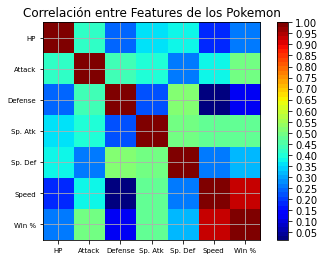

In [ ]:
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 50)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlación entre Features de los Pokemon')
    labels=['Type 1','HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win %']
    ax1.set_xticklabels(labels,fontsize=7)
    ax1.set_yticklabels(labels,fontsize=7)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[0.00,.05,.10,.15,.20,.25,.30,.35,.40,.45,.50,.55,.60,.65,.70,.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(results3.loc[:,col])

Las features con mayor correlación a porcentaje de victorias son "Velocidad" y "Ataque"


### **Machine Learning**

Seleccionamos el dataset con el que trabajaremos:

In [ ]:
dataset=results2

Dividimos los datos para entrenamiento y testeo. En este caso escogimos el típico 80%-20%. Usaremos las columnas 5 a la 11 para los datos X y la columna 15 (porcentaje de victorias) para el label (y).

In [ ]:
dataset.dropna(axis=0, how='any') # quitamos las filas con valores NA porque podrían causar errores
X = dataset.values[:,5:11]
y = dataset.values[:,15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### **Modelos de regresión**

#### Support Vector Regression (SVR)

In [ ]:
def ml_svm(X_train, X_test, y_train, y_test):
    from sklearn.svm import SVR
    regressor = SVR(kernel = 'linear')
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))

    y_pred= regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_svm(X_train, X_test, y_train, y_test)

0.9065078337237095


0.06360099438357145

#### Decision Tree Regression

In [ ]:
def ml_decisiontree(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeRegressor
    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))


    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_decisiontree(X_train, X_test, y_train, y_test)

0.9997364298486605


0.05381006518627112

#### Random Forest Regressor

In [ ]:
def ml_randomforest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(X_train, y_train)
    print(regressor.score(X_train, y_train))

    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    mae = mean_absolute_error(y_test, y_pred)
    return mae

ml_randomforest(X_train, X_test, y_train, y_test)

0.9900335696113418


0.04998334826451492

In [ ]:
all_stats = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

0.9065078337237095
0.9997364298486605
0.9900335696113418


### **Principle Component Analysis (PCA)**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Aplicamos PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# Nos da un vector de la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("This is the variance explained by the principle components")
print(explained_variance)

This is the variance explained by the principle components
[0.41314124 0.17695566 0.16108936]


Una vez que miramos cuanta varianza provoca cada variable independiente, debemos decidir cuantos componentes queremos para el modelos. Entre más componentes mayor será la varianza en el modelo. 

Ahora volveremos a correr los algoritmos de SVM, Decision Tree y Random Forest luego de PCA:

In [ ]:
PCA = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

0.7526006202791979
0.99973644025325
0.9602173159076051


Reducimos las features a tan solo velocidad y ataque:

In [ ]:
dataset = results2
dataset.dropna(axis=0, how='any')
# Dividimos el dataset en training y test
X = dataset.loc[:, ['Attack','Speed']].values
y = dataset.loc[:, ['porcenvictoria']].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

reduced_stats = [ml_svm(X_train, X_test, y_train, y_test), ml_decisiontree(X_train, X_test, y_train, y_test), ml_randomforest(X_train, X_test, y_train, y_test)]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9040040161126808
0.9930604360712907
0.9859902601183322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


### **Validación**

Luego de aplicar todos los modelos, comparemos los resultados:

In [ ]:
ml_results = pd.DataFrame({'Todos las estadísticas': all_stats, 'Estadísticas reducidas': reduced_stats, 'PCA': PCA})
ml_results.rename(index = {0:'SVM', 1:'Decision Tree', 2:'Random Forest'})

,Todos las estadísticas,Estadísticas reducidas,PCA
SVM,0.063601,0.064739,0.099990
Decision Tree,0.053810,0.054214,0.127740
Random Forest,0.049983,0.049369,0.096757


La tabla de arriba nos brinda una comparación en cuanto al error medio absoluto para cada modelo. El modelo con menor error fue el Random Forest con factores reducidos.

# CLASIFICADOR DE IMÁGENES

In [ ]:
#@title Importar librerías { display-mode: "form" }
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [ ]:
#@title Crear funciones { display-mode: "form" }

#Creates a dataset with bing searches with a structure
#  Dataset
#    Class1
#      Sample1
#      Sample2
#      ...
#      Samplen
#    ...
#    Classn
def create_dataset_from_bing(num_samples,search_terms,subscription_key,search_url,license='all',imageType='all',filetype='.jpg',path='/content'):
  #To obtain the information you need https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/
  for term in search_terms:
    os.chdir(path)
    try:
      os.mkdir(term)
    except OSError:
      continue
    if (path=='/'):
      os.chdir(path+term+'/')
    else:
      os.chdir(path+'/'+term)
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}
    params  = {"q": term, "license": license, "imageType": imageType, "filetype": filetype}

    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"][:num_samples]]

    i=0
    for url in thumbnail_urls:
      #print(url)
      r = requests.get(thumbnail_urls[i])
      i = str(i)
      img_name = term+i+filetype
      with open(img_name, "wb") as f:
        f.write(r.content)
      i = int(i)
      i=i+1

#Makes a list with all the classes in the dataset
def create_class_list(path_classes):
  classes_names = os.listdir(path_classes)
  classes_names.sort()
  return classes_names

#Filters the corrupt data images
def img_filter(classes_names):
  num_skipped = 0
  for folder_name in (classes_names):
    folder_path = os.path.join(path_classes, folder_name)
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      try:
        fobj = open(fpath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(fpath)
  print("Deleted %d images" % num_skipped)

#Makes a list of all the samples with its path
def dir_list(classes_names):
  list_dirs = []
  for i, name_class in enumerate(classes_names):
    list_dirs = list_dirs +[name_class+ "/"+ s for s in (os.listdir(path_classes + '/' + classes_names[i]))]
  list_dirs = np.array(list_dirs)
  return list_dirs

#Makes a list of all the samples with its corresponding label
def dir_list_class(classes_names,list_dirs):
  s=[]
  s_code=[]
  i = 0
  for name in classes_names:
    patron = name+'/'
    for img in list_dirs:
      if (img.startswith(patron)):
        s.append(name)
        s_code.append(i)
    i = i + 1
  files_class = pd.DataFrame(list_dirs,columns=['files'])
  files_class['class_name'] = pd.Series(s)
  files_class['class'] = pd.Series(s_code)
  return files_class

#Shows some data about the samples distribution (class balance)
def class_balance(classes_names,files_class):
  total = []
  print('summatory for class:\n')
  for name in classes_names:
    count = len(files_class[files_class['class_name']==name])
    print(name,'->',count)
    total.append(count)
  total = np.array(total)
  print('\nmean:',total.mean())
  print('standard deviation:',total.std())
  print('min value:',total.min())
  print('max value:',total.max())

#Slipts the data paths in two groups (train-test)
def dirs_split(files_class,train_percent):
  files_class = files_class.reindex(np.random.permutation(files_class.index))
  n = int(len(files_class)*train_percent)
  X = files_class['files']
  y = files_class['class']
  files_train = X.iloc[:n]
  classes_train = y.iloc[:n]
  files_test = X.iloc[n:]
  classes_test = y.iloc[n:]
  return files_train,classes_train,files_test,classes_test

#Load and preprocess the images in the  and classes paths
def make_data(files,classes):
  x = []
  y = []
  for image, clase in zip(files, classes):
    image = path_classes+'/'+image
    im = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    ima = tf.keras.preprocessing.image.img_to_array(im)
    x.append(ima)
    y.append(clase)
  x = np.array(x)
  y = np.array(y)
  return x,y

#Data normalization
def data_norm(x_train,y_train,x_test,y_test):
  x_train = x_train.reshape([-1, 224, 224, 3])
  x_test = x_test.reshape([-1, 224, 224, 3])

  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  y_test = tf.keras.utils.to_categorical(y_test)
  y_train = tf.keras.utils.to_categorical(y_train) 

  x_train /= 255
  x_test /= 255
  print('x_train shape:', x_train.shape)
  print('Number of images in x_train', x_train.shape[0], "y_train:", y_train.shape)
  print('Number of images in x_test', x_test.shape[0], "y_test: ", y_test.shape)

  return x_train,y_train,x_test,y_test

## Descargar el dataset

In [ ]:
#Mount at content/data or reate the directory if doesnt exists
try:
    os.mkdir('/content/data')
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")
os.chdir('/content/data')
print(os.getcwd())

Successfully created the directory
/content/data


Descargar de git

In [ ]:
!git clone https://github.com/Akshay090/pokemon-image-dataset

Cloning into 'pokemon-image-dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 637 (delta 1), reused 1 (delta 0), pack-reused 628
Receiving objects: 100% (637/637), 104.30 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Descargar de kaggle

In [ ]:
#os.environ['KAGGLE_USERNAME'] = "username" # username from the json file
#os.environ['KAGGLE_KEY'] = "key" # key from the json file
#!kaggle datasets download -d thedagger/pokemon-generation-one/download

 99% 329M/331M [00:18<00:00, 13.6MB/s]
100% 331M/331M [00:18<00:00, 19.0MB/s]


Crear dataset con búsquedas de Bing


In [ ]:
#create_dataset_from_bing(15,["Pikachu","Charizard","Mewtwo"],subscription_key = "bing_key",search_url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search",filetype='.png')

In [ ]:
!ls

pokemon-image-dataset


Si el dataset es descargado como un archivo comprimido

In [ ]:
#!unzip pokemon-5-dataset.zip

## Crear una lista con todas las clases (nombres de los pokemon)

In [ ]:
os.chdir('/content/data')

path_classes = 'pokemon-image-dataset/'
!ls ../data/pokemon-image-dataset/

bulbasaur  charmander  pikachu	README.md  squirtle


### Borrar directorios inútiles y problemáticos

El archivo ../data/pokemon-image-dataset/README.md no es útil, al igual que el directorio oculto ../data/pokemon-image-dataset/.git creado por git, por lo que ambos se eliminan

In [ ]:
!rm ../data/pokemon-image-dataset/README.md
!rm -r ../data/pokemon-image-dataset/.git

### Crea la lista con el directorio limpio de cosas innecesarias

In [ ]:
classes_names = create_class_list(path_classes)
num_class = len(classes_names)

print('List\n',classes_names)
print('\nNumber of classes\n',num_class)

List
 ['bulbasaur', 'charmander', 'pikachu', 'squirtle']

Number of classes
 4


## Filtrar imágenes corruptas

In [ ]:
img_filter(classes_names)

Deleted 242 images


## Crear dataset con las direcciones de las imágenes y su respectiva etiqueta

### Lista de todas las direcciones de las imagenes

In [ ]:
list_dirs = dir_list(classes_names) 
print("First element:",list_dirs[0], "  |  shape:",list_dirs.shape)
print('Total elements:', len(list_dirs))

First element: bulbasaur/00000115.jpg   |  shape: (363,)
Total elements: 363


### Dataset con la etiqueta para cada imagen

In [ ]:
files_class = dir_list_class(classes_names,list_dirs)
files_class

,files,class_name,class
0,bulbasaur/00000115.jpg,bulbasaur,0
1,bulbasaur/00000206.jpg,bulbasaur,0
2,bulbasaur/00000105.jpg,bulbasaur,0
3,bulbasaur/00000124.jpg,bulbasaur,0
4,bulbasaur/00000054.jpg,bulbasaur,0
...,...,...,...
358,squirtle/00000004.jpg,squirtle,3
359,squirtle/00000174.jpg,squirtle,3
360,squirtle/00000009.jpg,squirtle,3
361,squirtle/00000045.jpg,squirtle,3


## Análisis de los datos

### Balance de las clases

In [ ]:
class_balance(classes_names,files_class)

summatory for class:

bulbasaur -> 91
charmander -> 77
pikachu -> 132
squirtle -> 63

mean: 90.75
standard deviation: 25.791229129298976
min value: 63
max value: 132


Se observa un desbalance considerable ¿Podría usarse una función de aumento para tratar de mejorar esto un poco?

## Crear el dataset

### Separación de train y test (70% - 30%)

In [ ]:
train_percent = 0.7

files_train,classes_train,files_test,classes_test = dirs_split(files_class,train_percent)

#### Ver los datos

In [ ]:
files_train

165    charmander/00000150.jpg
218       pikachu/00000204.jpg
149    charmander/00000077.jpg
350      squirtle/00000090.jpg
190       pikachu/00000101.jpg
                ...           
124    charmander/00000170.jpg
4       bulbasaur/00000054.jpg
284       pikachu/00000017.jpg
254       pikachu/00000030.jpg
120    charmander/00000194.jpg
Name: files, Length: 254, dtype: object

In [ ]:
classes_train

165    1
218    2
149    1
350    3
190    2
      ..
124    1
4      0
284    2
254    2
120    1
Name: class, Length: 254, dtype: int64

In [ ]:
files_test

358      squirtle/00000004.jpg
355      squirtle/00000161.jpg
89      bulbasaur/00000027.jpg
52      bulbasaur/00000116.jpg
55      bulbasaur/00000143.jpg
                ...           
153    charmander/00000050.jpg
206       pikachu/00000001.jpg
199       pikachu/00000024.jpg
357      squirtle/00000141.jpg
59     bulbasaur/00000169.jpeg
Name: files, Length: 109, dtype: object

In [ ]:
classes_test

358    3
355    3
89     0
52     0
55     0
      ..
153    1
206    2
199    2
357    3
59     0
Name: class, Length: 109, dtype: int64

### Cargar las imagenes

#### Train

In [ ]:
x_train,y_train = make_data(files_train,classes_train)

print(x_train.shape)
print(y_train.shape)

(254, 224, 224, 3)
(254,)


#### Test

In [ ]:
x_test,y_test = make_data(files_test,classes_test)

print(x_test.shape)
print(y_test.shape)

(109, 224, 224, 3)
(109,)


In [ ]:
x_train,y_train,x_test,y_test = data_norm(x_train,y_train,x_test,y_test)

x_train shape: (254, 224, 224, 3)
Number of images in x_train 254 y_train: (254, 4)
Number of images in x_test 109 y_test:  (109, 4)


## Modelar la CNN

In [ ]:
model_CNN = tf.keras.models.Sequential()
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.MaxPooling2D((2, 2)))

model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())
model_CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())

model_CNN.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform', bias_initializer='he_uniform', padding='same'))
model_CNN.add(tf.keras.layers.BatchNormalization())

model_CNN.add(tf.keras.layers.Flatten())
model_CNN.add(tf.keras.layers.Dense(128, kernel_initializer='lecun_uniform', bias_initializer='lecun_uniform',  activation='relu'))

model_CNN.add(tf.keras.layers.Dense(num_class, activation='softmax'))

model_CNN.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      2

### Entrenar la red

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model_CNN.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_CNN.fit(x_train, y_train, epochs=50,verbose=1, batch_size=32,validation_data=(x_test, y_test))

Epoch 1/50
8/8 [==============================] - 9s 1s/step - loss: 412.0156 - accuracy: 0.5787 - val_loss: 4554.3984 - val_accuracy: 0.4954
Epoch 2/50
8/8 [==============================] - 5s 606ms/step - loss: 212.1821 - accuracy: 0.7992 - val_loss: 18033.7617 - val_accuracy: 0.2110
Epoch 3/50
8/8 [==============================] - 5s 602ms/step - loss: 110.6617 - accuracy: 0.9094 - val_loss: 10735.5410 - val_accuracy: 0.4128
Epoch 4/50
8/8 [==============================] - 5s 605ms/step - loss: 118.1943 - accuracy: 0.9252 - val_loss: 15871.8906 - val_accuracy: 0.4312
Epoch 5/50
8/8 [==============================] - 5s 606ms/step - loss: 26.3003 - accuracy: 0.9213 - val_loss: 44716.3867 - val_accuracy: 0.3578
Epoch 6/50
8/8 [==============================] - 5s 607ms/step - loss: 80.9579 - accuracy: 0.9055 - val_loss: 7315.9727 - val_accuracy: 0.5596
Epoch 7/50
8/8 [==============================] - 5s 603ms/step - loss: 32.4186 - accuracy: 0.9685 - val_loss: 5082.1118 - val_accu

In [ ]:
test_loss,test_acc = model_CNN.evaluate(x_test,y_test)

print('\nTest accuracy:',test_acc)
print('Test loss:',test_loss)

4/4 [==============================] - 0s 92ms/step - loss: 1151.0770 - accuracy: 0.7064

Test accuracy: 0.7064220309257507
Test loss: 1151.0770263671875


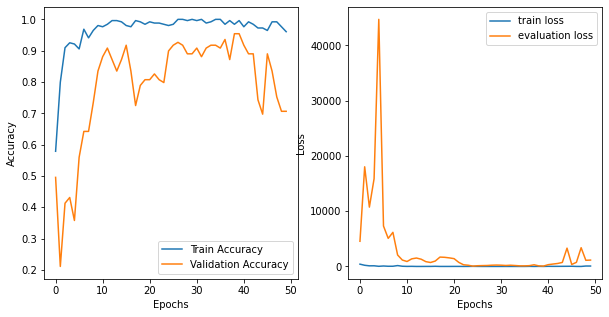

In [ ]:
#@title plot

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
model_A =  tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [ ]:
embedding_layer_1 = tf.keras.layers.Dense(256, kernel_initializer='normal', activation='relu')
embedding_layer_2 = tf.keras.layers.Dense(128, kernel_initializer='normal', activation='relu')
embedding_layer_3 = tf.keras.layers.Dense(num_class, activation='softmax')

flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # To mobilenet cnns

In [ ]:
model_B_on_A = tf.keras.Sequential([
  model_A,
  global_average_layer,
  embedding_layer_1,
  embedding_layer_2,
  embedding_layer_3
])

In [ ]:
model_B_on_A.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 2,619,332
Trainable params: 361,348
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_B_on_A.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_B_on_A.fit(x_train, y_train, epochs=20,verbose=1, batch_size=32,validation_data=(x_test, y_test))

Epoch 1/20
8/8 [==============================] - 2s 300ms/step - loss: 0.9382 - accuracy: 0.6378 - val_loss: 0.3797 - val_accuracy: 0.9174
Epoch 2/20
8/8 [==============================] - 1s 112ms/step - loss: 0.2103 - accuracy: 0.9724 - val_loss: 0.1296 - val_accuracy: 0.9633
Epoch 3/20
8/8 [==============================] - 1s 111ms/step - loss: 0.0682 - accuracy: 0.9882 - val_loss: 0.0759 - val_accuracy: 0.9908
Epoch 4/20
8/8 [==============================] - 1s 109ms/step - loss: 0.0350 - accuracy: 0.9843 - val_loss: 0.0652 - val_accuracy: 0.9633
Epoch 5/20
8/8 [==============================] - 1s 111ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9541
Epoch 6/20
8/8 [==============================] - 1s 112ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9817
Epoch 7/20
8/8 [==============================] - 1s 112ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9908
Epoch 8/20
8/8 [====

In [ ]:
test_loss,test_acc = model_B_on_A.evaluate(x_test,y_test)

print('\nTest accuracy:',test_acc)
print('Test loss:',test_loss)

4/4 [==============================] - 0s 64ms/step - loss: 0.0446 - accuracy: 0.9908

Test accuracy: 0.9908257126808167
Test loss: 0.044607531279325485


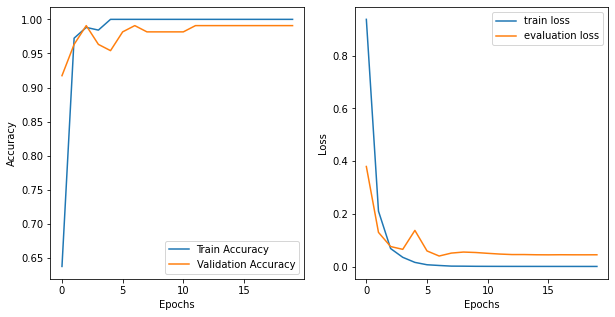

In [ ]:
#@title plot

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy');
ax.plot(history.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');